Copyright Vespa.ai. Licensed under the terms of the Apache 2.0 license. See LICENSE in the project root.


# ES


## Running the Elasticsearch docker container


```bash
docker run -p 9200:9200 -d --name elasticsearch --rm \
  -e "discovery.type=single-node" \
  -e "xpack.security.enabled=false" \
  -e "xpack.security.http.ssl.enabled=false" \
  -e "xpack.license.self_generated.type=trial" \
  docker.elastic.co/elasticsearch/elasticsearch:8.13.2
```


In [ ]:
!docker info

In [ ]:
import docker

client = docker.from_env()
docker_network = "my_network"

# Create a network if it does not exist
try:
    client.networks.get(docker_network)
    print(f"Network {docker_network} already exists")
except docker.errors.NotFound:
    client.networks.create(docker_network, driver="bridge")
    print(f"Network {docker_network} created")

container = client.containers.run(
    "docker.elastic.co/elasticsearch/elasticsearch:8.13.2",
    detach=True,
    ports={"9200/tcp": 9200},
    network=docker_network,
    name="elasticsearch",
    environment=[
        "discovery.type=single-node",
        "xpack.security.enabled=false",
        "xpack.security.http.ssl.enabled=false",
        "xpack.license.self_generated.type=trial",
    ],
)
# Wait until container is ready
container.reload()

In [ ]:
from elasticsearch import Elasticsearch
import json
import time

es = Elasticsearch("http://localhost:9200")
timeout = 30
while not es.ping():
    timeout -= 1
    if timeout == 0:
        raise TimeoutError("Elasticsearch is not ready")
    time.sleep(1)

In [ ]:
index_name = "product"

# Delete the index if it exists
if es.indices.exists(index=index_name):
    es.indices.delete(index=index_name)

In [ ]:
index_settings = {
    "settings": {"number_of_shards": 1, "number_of_replicas": 1},
    "mappings": {
        "properties": {
            "id": {"type": "integer"},
            "title": {"type": "text", "similarity": "BM25"},
            "description": {"type": "text", "similarity": "BM25"},
            "category": {"type": "keyword"},
            "price": {"type": "integer"},
            "average_rating": {"type": "float"},
            "embedding": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine",
                # See https://www.elastic.co/guide/en/elasticsearch/reference/current/dense-vector.html
                "index_options": {"type": "hnsw", "ef_construction": 200, "m": 16},
            },
        },
    },
}

# Create the index
es.indices.create(index=index_name, body=index_settings)

In [ ]:
# Pretty-print the mapping
mapping = es.indices.get_mapping(index=index_name)
mapping.raw

## Feed the data to the Elasticsearch container


In [ ]:
!sh feed_to_es.sh

In [ ]:
es.indices.refresh(index=index_name)
refresh_result = es.cat.count(index=index_name, params={"format": "json"})
refresh_result

In [ ]:
assert refresh_result[0]["count"] == "1000000"

For single file (<100MB):

```bash
curl -s -H "Content-Type: application/x-ndjson" -XPOST localhost:9200/_bulk --data-binary "@../dataprep/output-data/final/es_feed-10k.json"
```


## Query Elasticsearch


### Common function to retrieve query from file


In [ ]:
# Load the JSON data from the file
def get_single_query(application: str = "vespa", query_mode: str = "weak_and") -> dict:
    if application not in ["vespa", "es"]:
        raise ValueError("format must be 'vespa' or 'es'")
    if query_mode not in ["weak_and", "semantic", "hybrid"]:
        raise ValueError("query_mode must be 'weak_and', 'semantic', or 'hybrid'")
    filepath = (
        f"../dataprep/output-data/final/{application}_queries-{query_mode}-1.json"
    )
    with open(filepath, "r") as file:
        endpoint, query = file.read().splitlines()
        query_dict = json.loads(query)
    return query_dict

In [ ]:
bm25_query = get_single_query(application="es", query_mode="weak_and")
bm25_query

In [ ]:
results = es.search(index=index_name, body=bm25_query)
print("BM25 results: ", json.dumps(results.raw, indent=4))

### Semantic Query


In [ ]:
semantic_query = get_single_query(application="es", query_mode="semantic")
results = es.search(index=index_name, body=semantic_query)
print("Semantic search results:", json.dumps(results.raw, indent=4))

### Hybrid search - RRF


In [ ]:
hybrid_query = get_single_query(application="es", query_mode="hybrid")
results = es.search(index=index_name, body=hybrid_query)
print("Hybrid search results:", json.dumps(results.raw, indent=4))

## Running fbench against ES-container


Decompressing query-files


In [ ]:
!for f in ../dataprep/output-data/final/es_queries-*-10k.json.zst; do zstd -d -f "$f" -o "${f%.zst}"; done

### Docker command to run fbench against ES-container


```bash
docker run -v /Users/thomas/Repos/system-test/tests/performance/ecommerce_hybrid_search/dataprep/output-data/final:/files -w /files \
--network my_network \
--entrypoint /opt/vespa/bin/vespa-fbench \
vespaengine/vespa \
 -c 0 -s 5 -n 1 -q es_queries-weak_and-10k.json -P -o fbench_output_es_weak_and.txt -D elasticsearch 9200
```


In [ ]:
# Define the options and base filenames
options = ["weak_and", "semantic", "hybrid"]
base_query_file = "es_queries-{}-10k.json"
base_output_file = "fbench_output_{}.txt"
result_file = "fbench_results_{}.txt"
# Generate the configurations dynamically
configs = [
    {
        "option": option,
        "query_file": base_query_file.format(option),
        "output_file": base_output_file.format(option),
        "result_file": result_file.format(option),
    }
    for option in options
]

# Loop through each configuration and run the container
for config in configs:
    print(f"Running fbench in container for {config['option']} queries")
    output = client.containers.run(
        image="vespaengine/vespa",
        entrypoint="/opt/vespa/bin/vespa-fbench",  # Set vespa-fbench as the entrypoint
        network=docker_network,
        command=[
            "-c",
            "0",
            "-s",
            "30",
            "-n",
            "1",
            "-q",
            config["query_file"],
            "-P",
            "-o",
            config["output_file"],
            "-D",
            "elasticsearch",
            "9200",
        ],
        volumes={
            "/Users/thomas/Repos/system-test/tests/performance/ecommerce_hybrid_search/dataprep/output-data/final": {
                "bind": "/files",
                "mode": "rw",
            }
        },
        working_dir="/files",
        detach=False,
        remove=True,
    )

    # Wait for the container to finish and print the output
    result = output.decode("utf-8")
    print(f"Output for {config['option']} queries:\n{result}")
    # Save results to a file
    with open(config["result_file"], "w") as file:
        file.write(result)

In [ ]:
# Stop the ES container
container.stop()
container.remove()

In [ ]:
assert False  # Just to stop the execution here

# Vespa


## Starting the Vespa docker container

Be sure that your docker engine is running, and has at least 24GB of memory allocated to it.


In [2]:
import docker

client = docker.from_env()
docker_network = "my_network"
container_name = "vespa-ecommerce"
# Create a network if it does not exist
try:
    client.networks.get(docker_network)
    print(f"Network {docker_network} already exists")
except docker.errors.NotFound:
    client.networks.create(docker_network, driver="bridge")
    print(f"Network {docker_network} created")

container = client.containers.run(
    "vespaengine/vespa",
    detach=True,
    ports={"8080/tcp": 8080, "19071/tcp": 19071},
    network=docker_network,
    name=container_name,
)
# Wait until container is ready
container.reload()

Network my_network already exists


In [132]:
from vespa.deployment import VespaDocker

app_package_path = "../app/"

vespa_docker = VespaDocker(container=container, port=8080)
app_name = "ecommerce"

app = vespa_docker.deploy_from_disk(
    application_name=app_name, application_root=app_package_path
)

Waiting for configuration server, 0/300 seconds...
Waiting for configuration server, 5/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Waiting for application status, 0/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Waiting for application status, 5/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Waiting for application status, 10/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Application is up!
Finished deployment.


## Feed data to Vespa


In [130]:
!zstd -d -f ../dataprep/output-data/final/vespa_feed-20k.json.zst -o ../dataprep/output-data/final/vespa_feed-20k.json

pa_feed-20k.json.zst : 0 B...     

../dataprep/output-data/final/vespa_feed-20k.json.zst: 174607854 bytes         


In [133]:
!vespa config set target local
# unzstd the file
#!zstd -d -f ../dataprep/output-data/final/vespa_feed-1M.json.zst -o ../dataprep/output-data/final/vespa_feed-1M.json
!vespa feed --progress 5 ../dataprep/output-data/final/vespa_feed-20k.json

{
  "feeder.operation.count": 8013,
  "feeder.seconds": 5.000,
  "feeder.ok.count": 8013,
  "feeder.ok.rate": 1602.554,
  "feeder.error.count": 0,
  "feeder.inflight.count": 901,
  "http.request.count": 8013,
  "http.request.bytes": 31061553,
  "http.request.MBps": 6.212,
  "http.exception.count": 0,
  "http.response.count": 8013,
  "http.response.bytes": 891158,
  "http.response.MBps": 0.178,
  "http.response.error.count": 0,
  "http.response.latency.millis.min": 370,
  "http.response.latency.millis.avg": 543,
  "http.response.latency.millis.max": 1238,
  "http.response.code.counts": {
    "200": 8013
  }
}
{
  "feeder.operation.count": 18366,
  "feeder.seconds": 10.000,
  "feeder.ok.count": 18366,
  "feeder.ok.rate": 1836.586,
  "feeder.error.count": 0,
  "feeder.inflight.count": 886,
  "http.request.count": 18366,
  "http.request.bytes": 71185335,
  "http.request.MBps": 7.118,
  "http.exception.count": 0,
  "http.response.count": 18366,
  "http.response.bytes": 2042622,
  "http.resp

## Querying Vespa


### BM25


In [ ]:
bm25_query = get_single_query(application="vespa", query_mode="weak_and")
bm25_query

In [ ]:
from vespa.io import VespaQueryResponse

response: VespaQueryResponse = app.query(
    # Update to medium presentation summary
    body={**bm25_query, "presentation.summary": "medium"}
)
print(json.dumps(response.hits[:3], indent=4))

### Semantic search


In [ ]:
semantic_query = get_single_query(application="vespa", query_mode="semantic")
semantic_query

In [ ]:
response: VespaQueryResponse = app.query(
    # Update to medium presentation summary
    body={**semantic_query, "presentation.summary": "medium"}
)
print(json.dumps(response.hits[:3], indent=4))

### Hybrid query


In [ ]:
hybrid_query = get_single_query(application="vespa", query_mode="hybrid")
hybrid_query

In [ ]:
response: VespaQueryResponse = app.query(
    # Update to medium presentation summary
    body={**hybrid_query, "presentation.summary": "medium"}
)
print(json.dumps(response.hits[:3], indent=4))

## Running fbench against Vespa-container


In [ ]:
!for f in ../dataprep/output-data/final/vespa_queries-*-10k.json.zst; do zstd -d -f "$f" -o "${f%.zst}"; done

In [6]:
# Define the options and base filenames
options = ["weak_and", "semantic", "hybrid"]
base_query_file = "vespa_queries-{}-10k.json"
base_output_file = "fbench_output_vespa_{}.txt"
result_file = "fbench_results_vespa_{}.txt"
# Generate the configurations dynamically
configs = [
    {
        "option": option,
        "query_file": base_query_file.format(option),
        "output_file": base_output_file.format(option),
        "result_file": result_file.format(option),
    }
    for option in options
]

# Loop through each configuration and run the container
for config in configs:
    print(f"Running fbench in container for {config['option']} queries")
    output = client.containers.run(
        image="vespaengine/vespa",
        entrypoint="/opt/vespa/bin/vespa-fbench",  # Set vespa-fbench as the entrypoint
        network=docker_network,
        command=[
            "-c",
            "0",
            "-s",
            "30",
            "-n",
            "1",
            "-q",
            config["query_file"],
            "-P",
            "-o",
            config["output_file"],
            "-D",
            container_name,
            "8080",
        ],
        volumes={
            "/Users/thomas/Repos/system-test/tests/performance/ecommerce_hybrid_search/dataprep/output-data/final": {
                "bind": "/files",
                "mode": "rw",
            }
        },
        working_dir="/files",
        detach=False,
        remove=True,
    )

    # Wait for the container to finish and print the output
    result = output.decode("utf-8")
    print(f"Output for {config['option']} queries:\n{result}")
    # Save results to a file
    with open(config["result_file"], "w") as file:
        file.write(result)

Running fbench in container for weak_and queries
Output for weak_and queries:
Starting clients...
Stopping clients
Clients stopped.
.
Clients Joined.
*** HTTP keep-alive statistics ***
connection reuse count -- 11268
***************** Benchmark Summary *****************
clients:                       1
ran for:                      30 seconds
cycle time:                    0 ms
lower response limit:          0 bytes
skipped requests:              0
failed requests:               0
successful requests:       11269
cycles not held:           11269
minimum response time:      0.61 ms
maximum response time:     44.27 ms
average response time:      2.66 ms
25   percentile:              1.90 ms
50   percentile:              2.40 ms
75   percentile:              3.00 ms
90   percentile:              3.80 ms
95   percentile:              4.50 ms
98   percentile:              6.00 ms
99   percentile:              8.10 ms
99.5 percentile:             14.57 ms
99.6 percentile:             15.88 m

### Cleanup and remove Vespa container


In [ ]:
vespa_docker.container.stop()
vespa_docker.container.remove()

### Compare fbench output


Vespa results cleaned for weak_and - length: 11269
Elasticsearch results cleaned for weak_and - length: 5562


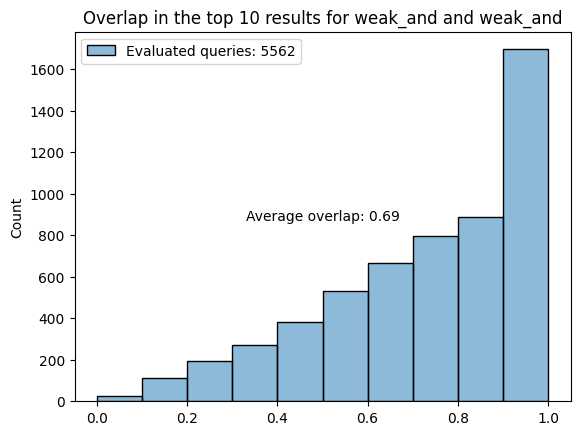

Vespa results cleaned for semantic - length: 16828
Elasticsearch results cleaned for semantic - length: 6804


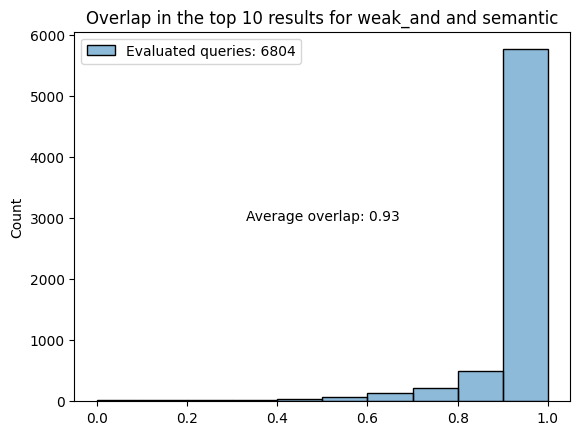

Vespa results cleaned for hybrid - length: 7494
Elasticsearch results cleaned for hybrid - length: 4130


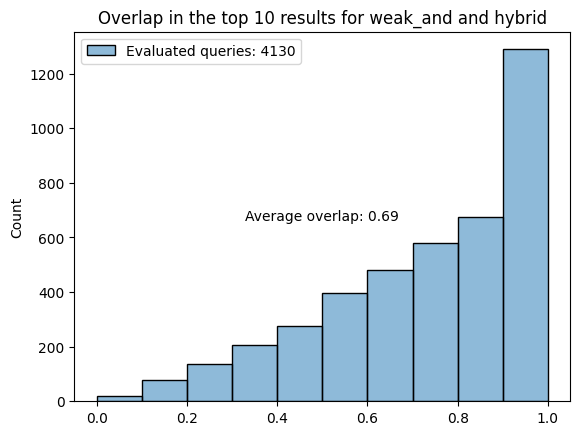

In [115]:
import json
from typing import Dict
import seaborn as sns
import matplotlib.pyplot as plt
import logging


def clean_results(result_file_path: str) -> Dict:
    vespa_in_file = "vespa" in result_file_path
    es_in_file = "es" in result_file_path
    if vespa_in_file:
        application = "vespa"
    elif es_in_file:
        application = "es"
    else:
        raise ValueError("File must be either vespa or es")
    all_results = {}
    query_id_counter = 1
    with open(result_file_path, "r") as file:
        lines = file.readlines()
        # Loop through each line in the file
        for line in lines:
            # keep only lines starting with {}
            if line.startswith("{"):
                # Load the line as a dictionary
                result_dict = json.loads(line)
                if application == "es":
                    # Extract hits from the dictionary
                    hits = result_dict["hits"]["hits"]
                    # Exctract id and score (named relevance) from each hit
                    individual_results = [
                        {"id": int(hit["_id"]), "relevance": hit["_score"]}
                        for hit in hits
                    ]
                elif application == "vespa":
                    # Extract the query_id from the dictionary
                    children = result_dict["root"]["children"]
                    individual_results = [
                        {"id": child["fields"]["id"], "relevance": child["relevance"]}
                        for child in children
                    ]
                # Assert length of results
                assert len(individual_results) <= 10, individual_results
                all_results[query_id_counter] = individual_results
                query_id_counter += 1
    return all_results


def calculate_overlaps(
    vespa_fbench_output_path: str, es_fbench_output_path: str
) -> float:
    vespa_results: dict = clean_results(vespa_fbench_output_path)
    print(f"Vespa results cleaned for {query_mode} - length: {len(vespa_results)}")
    es_results: dict = clean_results(es_fbench_output_path)
    print(f"Elasticsearch results cleaned for {query_mode} - length: {len(es_results)}")
    # Now we want to calculate the number of overlapping results in the top 10 for each query
    # We need to take only the lowest number of queries across the two systems
    min_queries = min(len(vespa_results), len(es_results))
    # Initialize the overlap counter
    overlap = {}
    # Loop through each query
    for query_id in range(1, min_queries + 1):
        # Get the top 10 results for each system
        vespa_top_10 = {result["id"] for result in vespa_results[query_id][:10]}
        es_top_10 = {result["id"] for result in es_results[query_id][:10]}
        # Calculate the overlap
        overlap[query_id] = len(vespa_top_10.intersection(es_top_10)) / 10
    return overlap


def plot_overlap(overlap: dict):
    # Plot a histogram of the overlap
    # One bin per 0.1 interval

    bins = [x / 10 for x in range(11)]
    # Create the histogram
    sns.histplot(overlap.values(), bins=bins)
    # Set the title
    plt.title(f"Overlap in the top 10 results for weak_and and {query_mode}")
    # Set a legend with total number of queries
    plt.legend([f"Evaluated queries: {len(overlap)}"])
    # Add another legend in center of plot with average overlap (to 2 decimal places)
    plt.text(
        0.5,
        0.5,
        f"Average overlap: {sum(overlap.values())/len(overlap):.2f}",
        horizontalalignment="center",
        verticalalignment="center",
        transform=plt.gca().transAxes,
    )
    # Show the plot
    return plt.show()


# File path to the uploaded file
querymodes = ["weak_and", "semantic", "hybrid"]

for query_mode in querymodes:
    vespa_fbench_output_path = (
        f"../dataprep/output-data/final/fbench_output_vespa_{query_mode}.txt"
    )
    es_fbench_output_path = (
        f"../dataprep/output-data/final/fbench_output_es_{query_mode}.txt"
    )
    overlap = calculate_overlaps(vespa_fbench_output_path, es_fbench_output_path)
    plot_overlap(overlap)
